#  Titanic Data Set
#### Hila Dar, Sep 2021


1. [Introduction](#Introduction) 
2. [Data Analysis and Data Visualization](#Data_Analysis_and_Data_Visualization)
3. [Preprocessing](#Preprocessing)
4. [Feature creation](#feat)
5. [Models](#models)
    1. [Bentchmark Models](#benchmark)
    2. [Random Forest](#rf)
    3. [Logistic Regression](#lr)
    4. [SVM](#svm)
    5. [k-Nearest Neighbors](#knn)
6. [Summary](#analze)
    


## Introducation  <a class="anchor" id="Introduction"></a>
### Historical Backgroud

* Titanic was a British passenger liner that sank in the North Atlantic Ocean on 15 April 1912, after striking an iceberg during her maiden voyage from Southampton to New York City.
* Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.
* The Titanic carried some of the wealthiest people in the world, as well as hundreds of emigrants who were seeking a new life in the United States. 
* The first-class accommodation was designed to be the pinnacle of comfort and luxury. Second class were often professors or authors. Third class accommodation was basic. Cabins slept up to 10 people and were located at the noisy bottom part of the ship close to the engines. 

**The Sinking**

* The carried lifeboats were enough for about half the passangers on board. A disproportionate number of men were left aboard because of a "women and children first" protocol for loading lifeboats.
* When the ship sank, all remaining passengers and crew were immersed in lethally cold water with a temperature of −2 °C and almost all of those in the water died in a minutes.
</u>

### Problem definition
What sorts of people were more likely to survive the Titanic sinking?

### Dataset 
Dataset contains boarding information of passengers (not crew).

The data has been split into two groups:
* train.csv 
* test.csv

train.csv contains the details of a subset of the passengers on board (891 passengers).
Using the patterns you find in train.csv, you have to predict whether the other 418 passengers on board (in test.csv) survived.

| Feature  | Description                                                          |
|----------|----------------------------------------------------------------------|
| Survival | Survival (0 = No; 1 = Yes)                                           |
| Pclass   | Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd)                          |
| Name     | Full name                                                            |
| Sex      | Sex                                                                  |
| Age      | Age                                                                  |
| Sibsp    | Number of Siblings/Spouses Aboard                                    |
| Parch    | Number of Parents/Children Aboard                                    |
| Ticket   | Ticket Number                                                        |
| Fare     | Passenger Fare                                                       |
| Cabin    | Cabin                                                                |
| Embarked | Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton) |

**libraries**

In [1027]:
# data analysis and wrangling
import pandas as pd
import numpy as np
from scipy import stats

# visualization
from IPython.display import Image
import seaborn as sns
import matplotlib.pyplot as plt

# machine learning
import statsmodels.api as sm

from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.metrics import precision_score,roc_curve,roc_auc_score, recall_score, accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler

#warnings 
import warnings
pd.options.mode.chained_assignment = None  # default='warn'
warnings.filterwarnings('ignore')

# plot settings:
CMAP = 'vlag'
fontfamily = "monospace"
context = "notebook"

color_main = 'gold'
my_colors = [color_main, 'salmon', 'wheat', 'red']


rc = {'axes.titlesize':18, 'axes.titleweight':'bold',
      'axes.labelweight':'bold', 'figure.figsize':[12,8], 
      'lines.linewidth':5, 'axes.edgecolor':'black',
     'boxplot.boxprops.color': color_main}

sns.set(context=context, font=fontfamily, rc=rc, style="whitegrid")
sns.set_palette(CMAP)

**loading the data**

In [1028]:
# Read CSV train data file into DataFrame
train_df = pd.read_csv("./train.csv")
test_df = pd.read_csv("./test.csv")

y_label = 'Survived'

# Looking for duplicates in the dataset
print(f"there are {train_df.duplicated().sum()} duplicated data-points")

there are 0 duplicated data-points


## Exploratory data analysis & Data Visualization <a class="anchor" id="Data_Analysis_and_Data_Visualization"></a>

In [1029]:
categorial_features = train_df.select_dtypes(include=['object']).columns.tolist()
numerical_features = train_df.select_dtypes(exclude=['object']).columns.tolist()

print(f'Categorical features: {categorial_features}')
print(f'Numerical features: {numerical_features}')
display(train_df[numerical_features].describe())
display(train_df[categorial_features].describe())

Categorical features: ['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']
Numerical features: ['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,4,644


### Mising Values <a class="anchor" id="missing"></a>

some values were omitted from data. It is not likely that the missing values were omitted from the table randomly. Its not unfounded that the missing values are the outcome of human mistake. For example maybe the missing age records, belongs to the last passangers to embark the ship? maybe, parents who bought tickets for the whole family wern't allways required to report the ages of their kids?

There are two features with high among of missing values - Cabin and Age. The passangers with missing Cabin values have lower survival rate than the rest.

In [1030]:
# checking correaltion between missing values and y_label
tmp = (train_df.isnull().sum().sort_values(ascending=False)/(train_df.shape[0]))
features_with_many_nan_values = tmp[tmp > 0.15].index
tmpy = train_df[~train_df[y_label].isnull()].copy()

    # checking null values per features: 
null_train = (train_df.isnull().sum().sort_values(ascending=False)/(train_df.shape[0])).round(3)

for feature in features_with_many_nan_values:
    tmpy["{}_is_null".format(feature)] = tmpy[feature].apply(lambda x:1 if pd.isnull(x) else 0)
    corr = np.corrcoef(tmpy["{}_is_null".format(feature)],tmpy[y_label])[0][1]
    print(f"correlation between {feature}_is_null and y_label = {corr:.2f}")
pd.DataFrame({"%-missing values - Train":null_train}).sort_values("%-missing values - Train", ascending=False).head(15)


correlation between Cabin_is_null and y_label = -0.32
correlation between Age_is_null and y_label = -0.09


,%-missing values - Train
Cabin,0.771
Age,0.199
Embarked,0.002
PassengerId,0.000
Survived,0.000
Pclass,0.000
Name,0.000
Sex,0.000
SibSp,0.000
Parch,0.000


This is a diagram of the Titanic. 
It sank from right to left. Thus, we expect to see  higher death rate in cabins which located closer to where the Titanic hit the iceberg.
It will be more dominant in class 3)

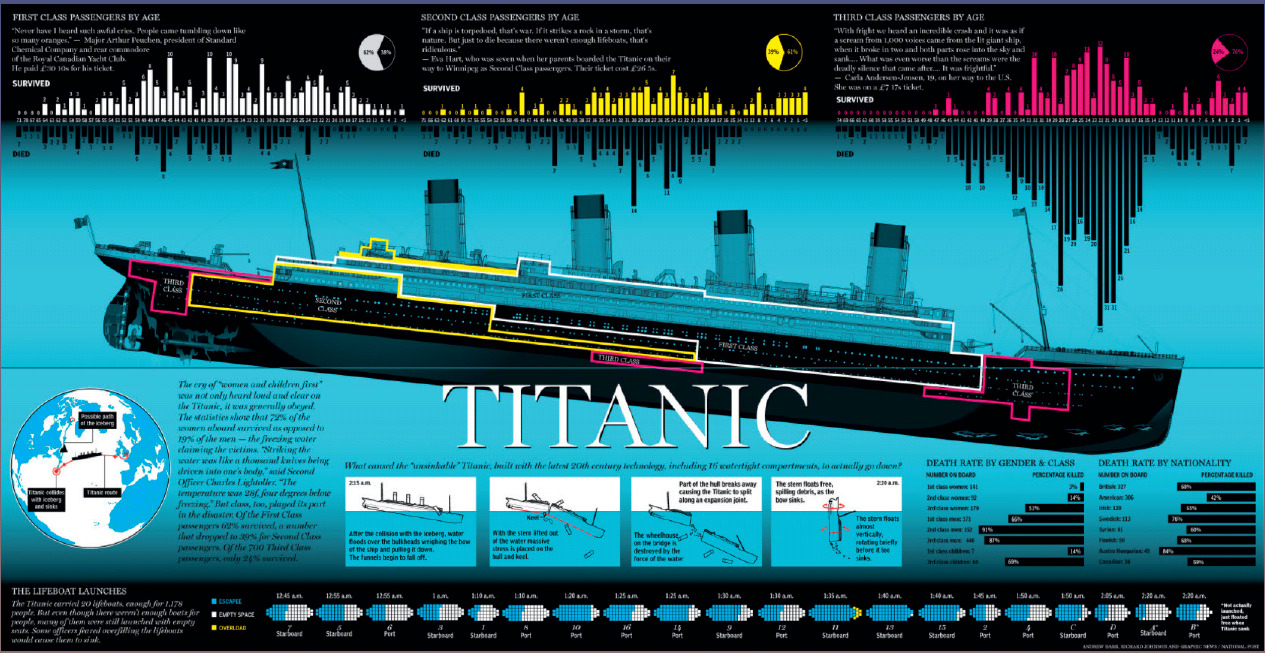

In [1031]:
Image("./images/titanic infographics.jpeg", width=1000)

### Features Distribution
* Total samples are 891 or 40% of the actual number of passengers on board the Titanic (2,224).
* Around 38% samples survived representative of the actual survival rate at 32%.
* Most passengers (> 75%) did not travel with parents or children.
* Nearly 30% of the passengers had siblings and/or spouse aboard.
* Fares distribution is right skewed 
* Few elderly passengers (<1%) within age range 65-80.

* Names are unique across the dataset (count=unique=891)
* Several passengers shared a cabin.
* Embarked takes three possible values. S port used by most passengers (top=S)
* Ticket feature is a combination of letters and numbers. It has high ratio (22%) of duplicate values (unique=681).

In [ ]:
categorical_features = ['Pclass', 'Sex', 'Cabin', 'Embarked','Parch','SibSp']
numerical_features = ['PassengerId', 'Age', 'Fare']

# Dist plot of all numberical features
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(15,4))
index, ax = 0, ax.flatten()
title = "numerical features distribution"
sample = train_df.reset_index()

for col in numerical_features:
    sns.kdeplot(data=sample, x=col,common_norm=False,hue=y_label,
                    palette=my_colors[:2],shade=True, edgecolor="black",
                    ax=ax[index]).set_title(f"{col} distribution", weight="bold")
    index += 1
plt.tight_layout(pad=0.5, w_pad=0.7, h_pad=3.0)
plt.savefig(f"./images/{title}.png") 


# Dist plot of all categorial features
title = "categorial features distribution"
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(15,5))
index, ax = 0, ax.flatten()

for col in categorical_features:
    sns.countplot(x=col, data=sample,ax=ax[index],alpha=1,hue=y_label, palette=my_colors[:2]).set_title(f"{col} barplot")
    ax[index].set_xlabel(f"{col}", weight="bold")
    ax[index].set_ylabel("count", weight="bold")
    index += 1
ax[0].tick_params(labelrotation=90)
plt.tight_layout(h_pad=0.0001)
plt.savefig(f"./images/{title}.png") 

**Survival rate as a function of different features**

In [ ]:
sample = ['Pclass', 'Sex','SibSp', 'Parch','Embarked']

# Dist plot of all categorial features
title = "Survival Rate"
fig, ax = plt.subplots(ncols=5, nrows=1, figsize=(20,5))
index = 0
ax = ax.flatten()

for col in sample:
    train_df.groupby(col)[y_label].mean().plot(kind='bar',color=color_main, ax=ax[index]).set_title(f"Survival rate by {col}", fontsize=13)
    ax[index].set_xlabel(f"{col}", weight="bold")
    ax[index].set_ylabel("Survival Rate", weight="bold")
    index += 1


ax[0].tick_params(labelrotation=90)
plt.tight_layout(h_pad=0.0001)
plt.savefig(f"./images/{title}.png") 

survival_rate_age_groups = pd.pivot_table(data=train_df, index=pd.cut(train_df["Age"],5), columns = "Sex", values = y_label, aggfunc="mean")
ax = survival_rate_age_groups.plot(kind="bar", color=my_colors)
title = "Survival rate in different age groups"
subtitle = "women survived more than men, rate increases with age only for woman"
ax.text(0,1.05,title,fontsize=21)
ax.text(0,1,subtitle,fontsize=16,fontweight='light')
plt.savefig(f"./images/survival_rate_age_group.png") 

### Features Joint Distribution

In [ ]:
def plot_features_correlation(dff,title = "features correlation"):
    ax = sns.clustermap(dff.corr(), annot=True, cmap='vlag',fmt='.0g',linewidths=3, figsize=(9,9), annot_kws={"fontsize":10})
    if y_label in dff.columns:
        series = np.abs(dff.corr()[y_label]).sort_values(ascending=False)
        print('The most linear correlated features with RainTomorrow are:')
        for i, row in enumerate(series):
            if 0.2 <= row < 1:
              print(f'{series.index[i]:17} --> {row: .2f} (abs)')
    ax.fig.suptitle(title, fontsize=20, weight="bold")
    plt.savefig(f"./images/{title}.png") 
plot_features_correlation(train_df)

**ticket fare and passenger class**

Oviously ticket prices were higher for higher classes. The variability in ticket prices seems to increase with the class as well.

In [ ]:
ax=sns.boxplot(x="Pclass", y="Fare", data=train_df, color=color_main, linewidth=1)
title = "Fare for different passanger classes"
subtitle = "Fare mean and variance increases with class"
ax.text(-0.15,575,title,fontsize=21,fontweight='bold')
ax.text(-0.15,550,subtitle,fontsize=16,fontweight='light')
plt.savefig(f"./images/{title}.png") 

**embarked and passenger class**

From where each class aboard the ship. This feature is highly correalted to Pclass (e.g. most of embarked C is 1st class)

In [ ]:
train_df.groupby(["Embarked", "Pclass"]).size()
total_size = train_df.shape[0]
count_embraked_pclass = pd.pivot_table(data=train_df, index="Embarked", columns = "Pclass", values=y_label, aggfunc="size")
total = count_embraked_pclass.sum(axis=1)
total_class = count_embraked_pclass.sum(axis=0)

tmp = count_embraked_pclass#
tmp["total embarked"] = total
tmp.loc["Total class"] = total_class
tmp.loc['Total class','total embarked'] = total.sum(skipna = True)
tmp

## Preprocessing <a class="anchor" id="Preprocessing"></a>


#### Completing
Age is the only important field that requires completion. A missing age value will be replaced by the mean of all passangers with the same name title:

In [ ]:
# get title:
train_df['Title'] = train_df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
test_df['Title'] = test_df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

# 1 if age is null, zero else.
train_df["age_null"] = train_df["Age"].isnull()
# show count and percent missing values for each title group:
display(train_df.groupby("Title").agg({"Age":["count", "mean", "std"], "age_null":"count"}).sort_values(("Age", "count"), ascending=False).dropna())

# trian:
fill_df = train_df.copy()
for title in train_df.Title.unique():
    mask_train = (fill_df["Title"] == title)
    fill_df.loc[mask_train, 'Age'] = train_df[mask_train]['Age'].mean(skipna=True) 

# fill missing values by the mean of the title group:
train_df["Age"] = train_df["Age"].fillna(fill_df["Age"])


# trian:
fill_df = test_df.copy()
for title in train_df.Title.unique():
    mask_train = (train_df["Title"] == title)
    mask_test = (test_df["Title"] == title)
    # fill the missing values in test, with the **train** values:
    fill_df.loc[mask_test, 'Age'] = train_df[mask_train]['Age'].mean(skipna=True) 


test_df["Age"] = test_df["Age"].fillna(fill_df["Age"])


print(f"there are {train_df['Age'].isnull().sum()} missing values in the data")
print(f"there are {test_df['Age'].isnull().sum()} missing values in the data")

In [ ]:
# fill embarked values by the mode
train_df['Embarked'] = train_df['Embarked'].fillna(train_df['Embarked'].mode()[0])

# fill test fare values by the median of the **Train** in the same class
def get_median_of_train_by_group(group_value, group="Pclass", field="Fare"):
    fill_values = dict(train_df.groupby(group)[field].median())
    return fill_values[group_value]

test_df["Fare"] = test_df["Fare"].fillna(test_df["Pclass"].apply(get_median_of_train_by_group))



**Correcting**
1. Cabin feature may be dropped as it is highly incomplete or contains many null values both in training and test dataset. 
combinig with our domain knowledege we know it wasn't very important for survival (and also there are many cabins. will increase the number of feature and make overfitting.)
2. PassengerId may be dropped from training dataset.
3. Name feature is relatively non-standard, may not contribute directly to survival, so maybe dropped.
4. Fare may be dropped.

**Creating**


1. We may want to engineer the Name feature to extract Title as a new feature. (will help us to fill missing age values, as can seen below.)
2. We may want to engineer the Name feature to extract Sur name as a new feature.(??)
3.We may want to create a new feature ticker group size - will help us with determing weather the passenger travled alone.
4. We may want to create a new binaric feature is Travelled alone
(Parch + SibSp)/ ticker group size.
5. we will give up filling age missing values directly. 
crete  levels feature: is child, adult, old. 
we are going to use all the above features.


This turns a continous numerical feature into an ordinal categorical feature.

## Feature creation / selection <a class="anchor" id="feat"></a>

##### has family
A passanger is traveling with a family if he/she has at least one parent or sibling on board.

In [ ]:
# create feature has_family:
train_df["has_family"] = (train_df['SibSp'] + train_df['Parch'] >= 1).astype(int)
test_df["has_family"] = (test_df['SibSp'] + test_df['Parch'] >= 1).astype(int)

# plot survival rate of the feature across different classes:
mask = np.where((train_df['SibSp'] + train_df['Parch']) >= 1 , 'Family', 'No Family')
tmp = pd.pivot_table(data=train_df, index=mask, columns = "Pclass", values = y_label, aggfunc="mean")
ax = tmp.plot(kind="bar", color=my_colors)
#ax = train_df.groupby(mask)['Survived'].mean().plot(kind="bar", color=color_main)

title = "Survival rate with and without family"
subtitle = "passangers with family survived more, regardless of class"

ax.text(-0.2,0.81,title,fontsize=21,fontweight='bold', fontfamily='monospace')
ax.text(-0.37,0.78,subtitle,fontsize=16,fontweight='light', fontfamily='monospace')
ax.tick_params(labelrotation=0, labelsize=15)
plt.savefig(f"./images/{title}.png") 

As we can see below, the three categorical features Sex, Class and has_family, explain most of the variation in y_label:
1. More than 90% of the women from 1st and 2nd classess survived
2. ~85% of men from 2nd and third classess didn't survived, and ~90% of them that travel alone died. 

This means that we can create a simple prediction with ~90% accuracy for at least the ~60% of the passangers following under conditions (1) or (2)

In [ ]:
# split the data into different buckets of Class-Sex-has_family, take the mean survival rate in each bucket:
survival_rate_by_sex_family_class = pd.pivot_table(data=train_df, index="Pclass", columns = ["Sex", "has_family"], values = y_label, aggfunc="mean")

# plot settings:
fig, ax = plt.subplots(figsize=(13,10)) 
heatmap_colors = ['red','salmon', 'wheat', 'gold']
xticks = ["Female-Alone", "Female- with Family","Male-Alone", "Male- with Family"]
title = 'Survival rate across the three categorical features'
sns.heatmap(survival_rate_by_sex_family_class, annot=True, cmap=heatmap_colors,fmt='.2g',linewidths=3, ax=ax,annot_kws={"fontsize":20}).set_title(title, fontsize=22)
ax.set_xticklabels(xticks, fontsize=14)
ax.set_yticklabels(['1st','2nd', '3rd'],fontsize=14)
ax.set_xlabel("Sex x Family",fontsize=20)
ax.set_ylabel("Class",fontsize=20)
plt.savefig(f"./images/{title}.png") 

##### Pclass
As shown above, higher class indicates higher survival rates. There is a natural ordering for this categorial field which corresodnges to higher survival rates. Hence, I chose to use this field as a *numerical* feature.

##### Fare
Ticket fare has two major problems:
* it is highly correalted with the passanger class (with 1st class being the most expensive). Ideally I'd like to use only the uncorrelated component of Fare (i.e. how expensive is the ticket compare to other passangers in the same class)
* it is heavy tailed

Hence I transform the fare price to the rank of the price in the class. The most expensive ticket in each class gets the value 1, the median 0.5 and the least expensive 0. 


In [ ]:
print(f"correlation Fare and Class = {train_df[['Fare', 'Pclass']].corr().iloc[0,1]:.2f}")

In [ ]:
ax = sns.boxplot(x="Pclass", y="Fare",data=train_df,hue=y_label, palette=my_colors[:2],linewidth=1)
title = "Fare for different passanger classes"
subtitle = "higher realtive prices indicates higher survival rates"
ax.text(-0.15,575,title,fontsize=21,fontweight='bold')
ax.text(-0.25,550,subtitle,fontsize=16,fontweight='light')
plt.show()

train_df['ranked_fare'] = train_df.groupby("Pclass")["Fare"].rank(pct=True)
test_df['ranked_fare'] = test_df.groupby("Pclass")["Fare"].rank(pct=True)
title = "Ranked ticket prices and survival rate"
ax = sns.boxplot(x="Pclass", y="ranked_fare",data=train_df,hue=y_label, palette=my_colors[:2],linewidth=1).set_title(title)
plt.savefig(f"./images/{title}.png") 

##### Dummy variables

In [ ]:
# create dummy variables:
train_df_w_dummies = pd.get_dummies(train_df, columns=['Sex','Embarked'], drop_first=True)
test_df_w_dummies = pd.get_dummies(test_df, columns=['Sex','Embarked'],drop_first=True)

##### Final feature selection

In [ ]:
# final features selection:
features = ['Pclass', 
            'Sex_male',
            'Age',  
            'ranked_fare',
            'Embarked_Q', 'Embarked_S',
       'has_family']


# define X and y:
y_train = train_df_w_dummies[[y_label]]
y_train, y_train.astype('int')
X_train, X_test = train_df_w_dummies[features], test_df_w_dummies[features]

features_names = X_train.columns

##### Normalization
I use zscore to normalize the data (important for logistic regression, svm and knn). I decided to apply this transofrmation to the dummy variables as well.  

In [ ]:
# Normalize train.
scaler = StandardScaler(with_mean=True, with_std=True)
scaler.fit(X_train)

X_train_norm = scaler.transform(X_train)   # inculding dummy variables!
X_test_norm = scaler.transform(X_test)     # reduce the mean and divide by the std of the **train**

## Models <a class="anchor" id="models"></a>

In [943]:
# import long functions:
from utils import *

def plot_results_vs_param(param, score = score, data=data, results=results, title = ''):
    results.groupby(f"param_{param}")[f"mean_{data}_{score}"].mean().plot(kind='bar', color=color_main).set_title(title)
    plt.show()

# save all classifiers in a dict
all_classifiers = {}
class_names = ["Died", "Survived"]

### Benchmark models <a class="anchor" id="benchmark"></a>
We set a benchmark models to better evaluate our model performance:
1. "everyone dies model" - predicts always 0. This model has 62% accuracy.
2. "women and childern survive" model - predicts 1 if the passanger is either a woman or under 15, 0 else.  This model has 63% accuracy.

In [736]:
# "everyone dies model"
print('"everyone dies model')
dummy_clf = DummyClassifier(strategy='most_frequent', constant=0)
dummy_clf.fit(X_train, y_train)
print(classification_report(y_train, dummy_clf.predict(X_train), target_names=class_names))

# "women and childern survive" model
print('"women and childern survive" model')
y_pred = ((X_train["Age"] < 15) & (X_train['Sex_male'] == 0)).astype(int)
print(classification_report(y_train, y_pred, target_names=class_names))

"everyone dies model
              precision    recall  f1-score   support

        Died       0.62      1.00      0.76       549
    Survived       0.00      0.00      0.00       342

    accuracy                           0.62       891
   macro avg       0.31      0.50      0.38       891
weighted avg       0.38      0.62      0.47       891

"women and childern survive" model
              precision    recall  f1-score   support

        Died       0.63      0.97      0.76       549
    Survived       0.62      0.07      0.13       342

    accuracy                           0.63       891
   macro avg       0.62      0.52      0.44       891
weighted avg       0.62      0.63      0.52       891



### Random Forest <a class="anchor" id="rf"></a>

#### Random Search

I used CV random search to tune the optimal parameters for the model. I defined a large grid space of possible parameters and sample it randomly. Here is how I handle the different parametrs: 

**params**


Forest Design:
* **n_estimators** - the loss (in train and test) converges to the same value as a function of the number of trees. Hence, I chose to use one large number of trees (e.g. 250 to a dataset of size 900), and not try out mulitple different values.
* **max_depth** - the depth of the trees is choosen using random search. Larger depth will exponentially incrsrease the complexity of the model (e.g. at depth of log_2 ( n ) for n number of samples, we would have 100% accuracy in during training ). 
* **min_samples_split**, **min_samples_leaf** - other ways to restrict the size of the trees. In addition to searching for different values of max_depth, we will randomlly search for different design for the trees in those parametres. If we use high restriction on the size the leaf, we can use deeper depth and vice versa. 

Boostrap:
* **bootstrap** - we will use boostrap in our model to increase diversity among trees.
* **max_features** - Increasing max_features generally improves the performance of the model as at each node now we have a higher number of options to be considered. However, it will decrease the diversity among the trees. As a rule of thumb I use the standard sqrt(p) for p number of features.

Loss Function:
* **class_weight** - our data is roughly 78-22% imbalance. We will oversample from the minority class to overcome the problems associated with imbalance prediction.
* **oob_score** - I always use OOB score, to better estimate the classification error
* **criterion** - gini, entropy or accuracy - all of them or similiar. Gini and entropy are differentiable and hence more amenable to optimization. Entropy and gini are more sensitive to changes in the node probabilities than accuracy (e.g. improving the classificaiton from 0.7 to 0.8 will result in less of a reduction in the loss function compare to 0.8 to 0.9)


In [978]:
search_param = {
    'max_depth' : np.arange(4,11),                    # 10 is an upper bound, as 2^10 > datasize
    'min_samples_leaf': np.arange(2,12,1),
    'class_weight':['balanced',None],
}

# seting, but not searching the following:
fixed_params = {
    'n_estimators':250,                                # large enough for this dataset. 
    'criterion':"gini",                                # gini is differentiable and more sensitive to changes in the node probabilities (compared to accuracy)
    'bootstrap':True,'max_samples':0.7,                # sampling only 70% (of the CV dataset) will diversify the trees
    'max_features':round(np.sqrt(X_train.shape[1])),   # I use sqrt(p) for classification problems
    'oob_score':'True'                                 # always used OOB score for best estimation of the error. 
}


rf = RandomForestClassifier(**fixed_params)                     

clf = RandomizedSearchCV(rf, search_param,  cv=3, scoring = ['accuracy', 'f1','precision','recall','roc_auc'],
                         refit=False, verbose=1,  n_iter=100,return_train_score=True)

In [979]:
clf.fit(X_train_norm, y_train.values.ravel())
results_rf = pd.DataFrame(clf.cv_results_)
results_rf["param_class_weight"] = results_rf["param_class_weight"].fillna("None")
results_rf.to_csv(f'RandomSearch_results/{svm.__class__.__name__}.csv')

Fitting 3 folds for each of 125 candidates, totalling 375 fits


#### Results Analysis
* When using inverse-class-size weighted loss function (i.e. "Balanced" flag), when get slightly higher F1 score in test (as expected)
* The average test accuracy on the entire space is around 80% (better than benchmark)
* As expected, in high levels of min-leaf-size, the trees are pruned in depth lower than max_depth

NameError: name 'results_rf' is not defined

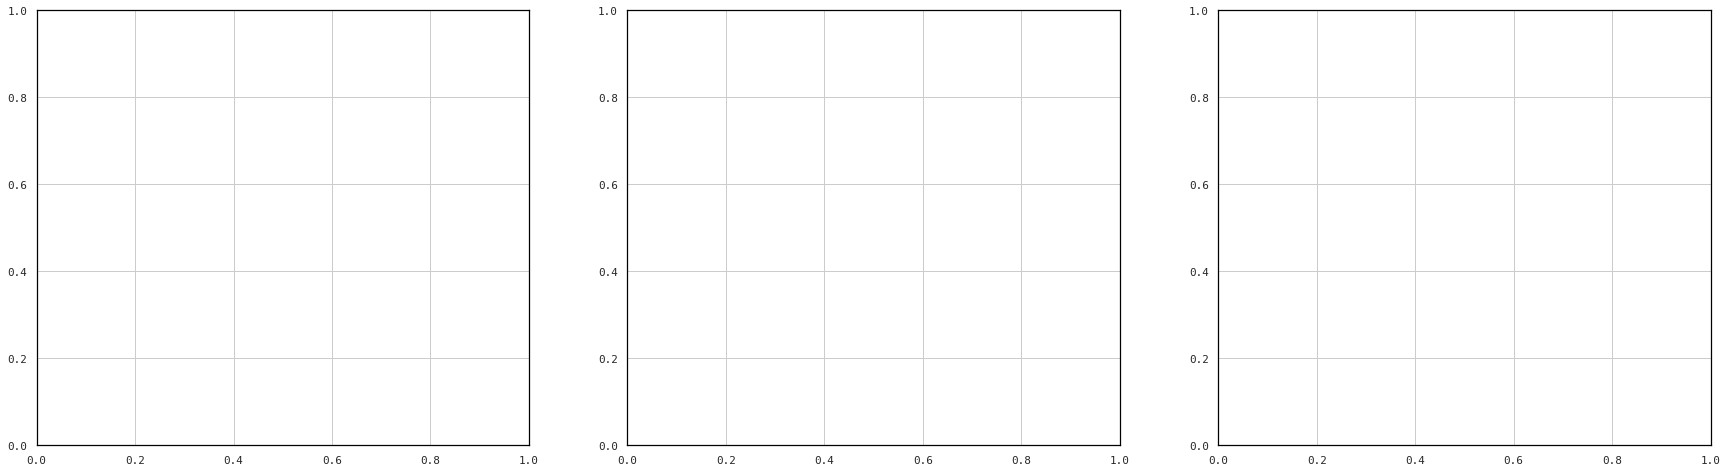

In [989]:
def plot_results_vs_param(param, results, score = 'accuracy', data='test',ax=None , title = ''):
    results.groupby(f"param_{param}")[f"mean_{data}_{score}"].mean().plot(kind='bar', edgecolor="black", color=color_main, ax=ax).set_title(title)

# plot settings
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(30,8))
index, ax = 0, ax.flatten()

# compare f1 score of class_weight=Balanced vs class_weight=None
plot_results_vs_param("class_weight", results_rf, ax=ax[0], score = 'f1', data="train",title=f"test {score} score, Balanced vs None")
ax[0].tick_params(labelrotation=0)

# compare accuracy scores train vs test:
score = 'accuracy'
sns.kdeplot(data=results_rf, x=f"mean_{data}_{score}", shade=True, edgecolor="black",color=my_colors[1], label=f"test_{score}", ax=ax[1])
sns.kdeplot(data=results_rf, x=f"mean_train_{score}", shade=True, edgecolor="black",color=my_colors[0], label=f"train_{score}", ax=ax[1]).set_title("Train vs Test Accuracy Distribution")
ax[1].legend(labels=['Test Accuracy','Train Accuracy'], prop={'size': 20})


# compare accuracy Test
title = f"{score} Test"
pivot = pd.pivot_table(data=results_rf, index = "param_min_samples_leaf", columns = "param_max_depth", values = f"mean_test_{score}", aggfunc="mean")
sns.heatmap(pivot, annot=True, ax=ax[2], fmt='.2g', cmap = "vlag").set_title(title, fontsize=18)
ax[0].set_xlabel('Max Depth of tree', fontsize=18)
ax[0].set_ylabel('Min leaf size', fontsize=16)
ax[0].tick_params(axis='both', which='major', labelsize=20, labelrotation=0)



based on the results above, we will fit a forest with the following params:
* weighted average loss function
* leaf >= 5, to avoid overfitting.

{'n_estimators': 250, 'criterion': 'gini', 'bootstrap': True, 'max_samples': 0.7, 'max_features': 1, 'oob_score': 'True', 'min_samples_leaf': 5, 'max_depth': 10, 'class_weight': 'balanced'}
              precision    recall  f1-score   support

           0       0.90      0.88      0.89       549
           1       0.82      0.84      0.83       342

    accuracy                           0.87       891
   macro avg       0.86      0.86      0.86       891
weighted avg       0.87      0.87      0.87       891

mean_of_predict=0.40 (actual = 0.38%)


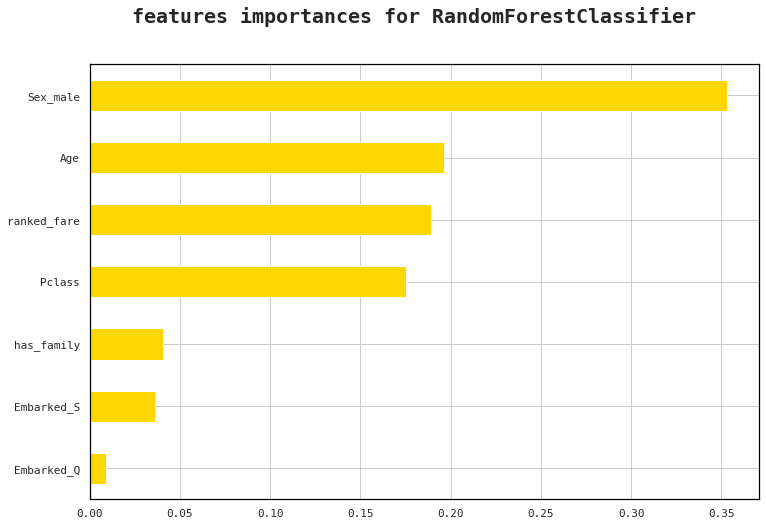

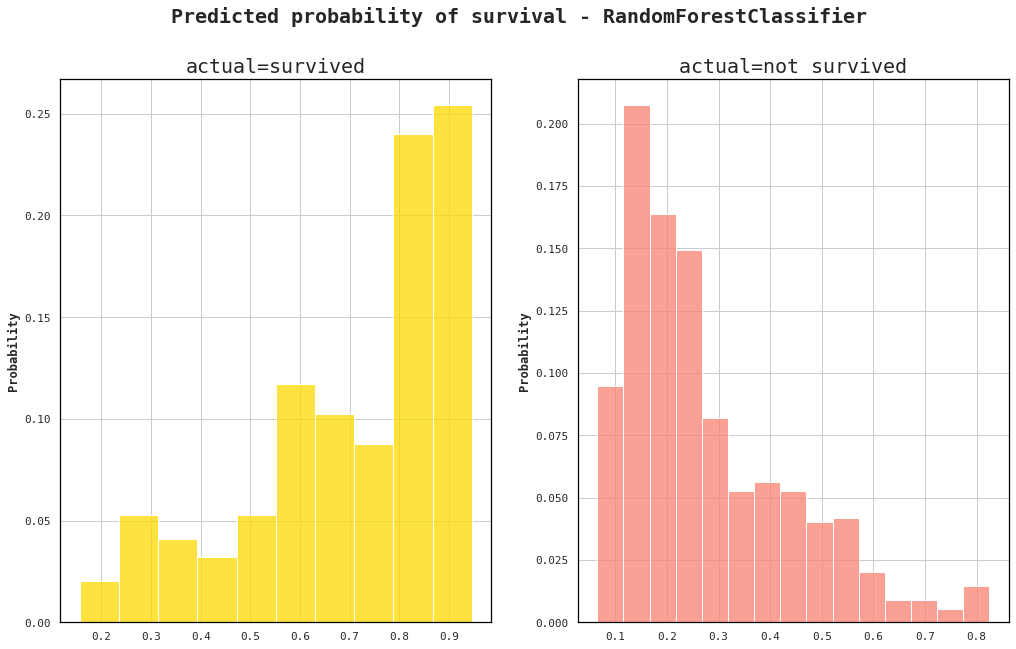

In [980]:
score = 'f1'  # scoring func

filter_mask = (results["param_min_samples_leaf"] >= 5) & (results["param_class_weight"] == "balanced")
params = results[filter_mask].sort_values(f'mean_test_{score}', ascending=False).iloc[0]['params']
params = {**fixed_params, **params}
print(params)

# fit model based on optimal params
rf = RandomForestClassifier(**params)
rf.fit(X_train_norm, y_train.values.ravel())

all_classifiers[rf.__class__.__name__] = rf

# having chosen the best model in CV, the Train performance below might not represent the actual Test performance 
evaluate(rf, X=X_train_norm, y=y_train, feature_importance=True, features_names=features_names)
plot_predicated_probability(rf, X_train_norm, y_train,y_label)

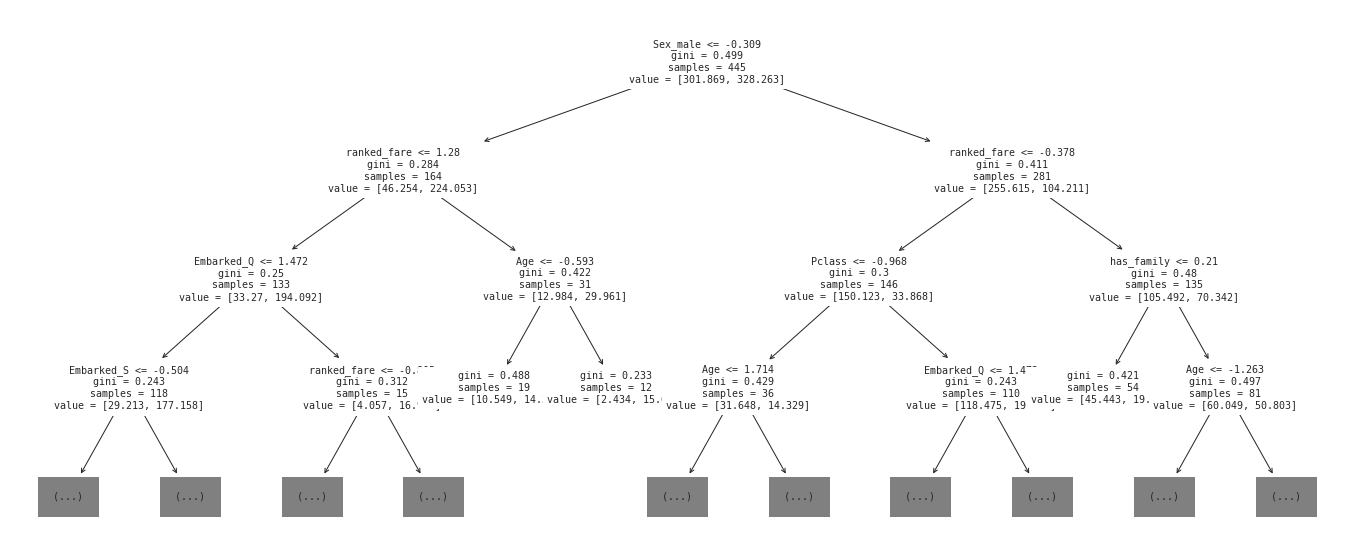

In [1026]:
# plot one tree sample:
plt.figure(figsize=(24,10))  # set plot size (denoted in inches)
tree.plot_tree(rf.estimators_[42], fontsize=10, max_depth=3, feature_names=features_names)
plt.show()

### Logistic regression <a class="anchor" id="lr"></a>
#### Theoritical backgroud

Let there X,Y.

<u>Assumptions:</u> P(Y=1|X) = Sigmoid(<$\beta$ ,X> + $\beta_0$> where $\beta\in\mathbb{R}^p,\beta_0\in\mathbb{R}$

<u>$\beta$ Estimation Strategy:</u> find $\beta$ such that $P(\bigcap_{i=1}^{n}(x_{i},y_{i}))$  is maximal (MLE).
$\iff$ minimize $\sum_{i=1}^{n}y_{i}*log(P(y_i=1|X=x_i))+(1-y_{i})*log(1-P(y_{i}=1|X=x_i))$

We minimize this <b>loss function</b> using convex optimization techniques (e.g gradient descent), NOT analytically.

**Regularization**

<u>motivation:</u> MLE, often have low bias but large variance. sometimes, by shrinking or setting some coef to 0, we might scrifice a little bit of bias but reduce the variance of the predicted values and hence may improve the overall prediction accuracy. another reason is interpetation. with large number of predictors, it may be hard to get the 'big picture'.

<u>Solution:</u> Adding a regularization term (or regularizer) 
to the loss function: $\lambda * R(f)$. 
$\lambda$ is a parameter which controls the importance of the regularization term. R(f) is chosen to impose a penalty on the complexity of f.
opular techniques we are going to apply: 
-  $L_1$ penalty (LASSO): 
    
    R(f)= $\sum_{i=1}^{p}|\beta_{i}|$, thus:
    $\hat{\beta} = argmin_{\beta} (Loss(\beta) + \lambda \Vert\beta\Vert_1$) or equivalently: $\hat{\beta} = argmin_{\beta} (Loss(\beta)$), such that $\Vert\beta\Vert_1\leq t$ t*$\lambda$ = 1.

-  $L_2$ penalty (Ridge):  R(f)= $\sum_{i=1}^{p}\beta_{i}^{2}$ 

<u>remarks:</u>
-  Lasso & Ridge are techniques that penalize large coefficients. If the variables are on different scales, the techniques will tend to just penalize variables on the smallest scale as they will have the largest coefficient. Thus it is highly recommended to make sure all varibales are on the same scale. 
-  Lasso set some coefficients to 0, thus, compared to regular logistic regression, the score on train is necessarily lower.

#### Results Analysis
* Lasso and ridge both underperformed simple logisitic regression, probabiliy because we don't have a lot of features. 
* Once again, it is better to use balanced class weight.

In [981]:
search_param = {
        'penalty' : ['l1','l2','none'],           # Lasso, ridge or None.
        'C' : np.logspace(-4, 4, 20),             # smaller values specify stronger regularization. 
        'class_weight' : ['balanced',None]        # weighted loss function
}


# setting, but not searching the following:
fixed_params = {
    'max_iter' :300, 
    'fit_intercept':True,
    'solver' :'saga',
    'intercept_scaling' :1
}


lr = LogisticRegression(**fixed_params)                 

clf = RandomizedSearchCV(lr, search_param,  cv=3, scoring = ['accuracy', 'f1','precision','recall','roc_auc'],
                         refit=False, verbose=1,  n_iter=120,return_train_score=True)


In [982]:
clf.fit(X_train_norm, y_train.values.ravel())
results_lr = pd.DataFrame(clf.cv_results_)
results_lr["param_class_weight"] = results_lr["param_class_weight"].fillna("None")
results_lr.to_csv(f'RandomSearch_results/{svm.__class__.__name__}.csv')

Fitting 3 folds for each of 120 candidates, totalling 360 fits


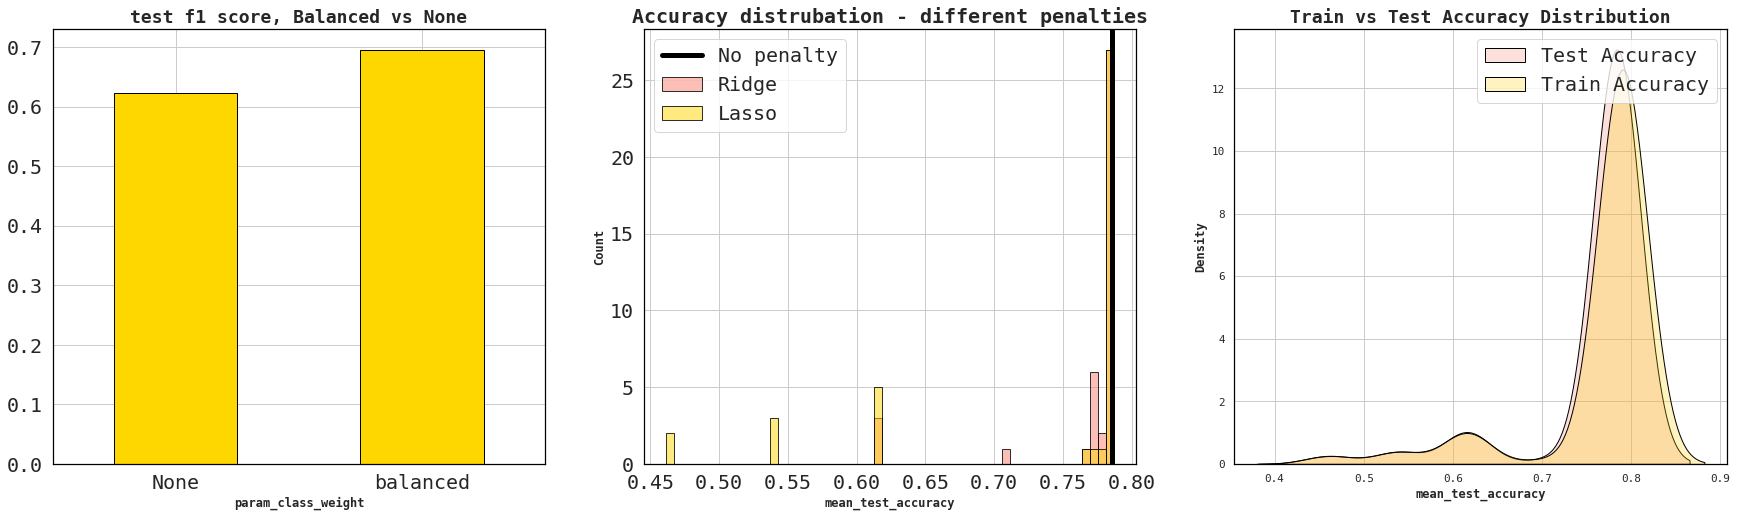

In [983]:
# plot settings
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(30,8))
ax = ax.flatten()

# compare f1 score of class_weight=Balanced vs class_weight=None
plot_results_vs_param("class_weight", results_lr, ax=ax[0], score = 'f1', data="train",title=f"test {score} score, Balanced vs None")
ax[0].tick_params(axis='both', which='major', labelsize=20, labelrotation=0)

sns.histplot(data=results_lr[results_lr['param_penalty'] != 'none'], x="mean_test_accuracy", ax=ax[1],  hue='param_penalty', 
            edgecolor="black",common_norm=False,palette = my_colors[:2]).set_title("Accuracy distrubation - different penalties", fontsize=20)
ax[1].axvline(x=results_lr[results_lr["param_penalty"] == 'none']["mean_test_accuracy"].mean(), label="no-penalty", color='black')
ax[1].legend(labels=['No penalty','Ridge','Lasso'], prop={'size': 20})
ax[1].tick_params(axis='both', which='major', labelsize=20, labelrotation=0)


# compare accuracy scores train vs test:
score = 'accuracy'
sns.kdeplot(data=results_lr, x=f"mean_{data}_{score}", shade=True, edgecolor="black",color=my_colors[1], label=f"test_{score}", ax=ax[2])
sns.kdeplot(data=results_lr, x=f"mean_train_{score}", shade=True, edgecolor="black",color=my_colors[0], label=f"train_{score}", ax=ax[2]).set_title("Train vs Test Accuracy Distribution")
ax[2].legend(labels=['Test Accuracy','Train Accuracy'], prop={'size': 20})
plt.savefig(f"./images/LR_search_results.png") 

In [984]:
# choose params based on the analysis above:
params = {'penalty':'none', "class_weight":'balanced'}
params = {**fixed_params, **params}
print(params)

# train the model with the optimal CV params again on the entire data:
lr = LogisticRegression(**params)
lr.fit(X_train_norm, y_train.values.ravel())

all_classifiers[lr.__class__.__name__] = lr

{'max_iter': 300, 'fit_intercept': True, 'solver': 'saga', 'intercept_scaling': 1, 'penalty': 'none', 'class_weight': 'balanced'}


Based on the p-values of the features below, we can see that logistic regression effectively consider only three features: Sex, Age and Class.

In [304]:
sm_model = sm.Logit(y_train, sm.add_constant(X_train_norm)).fit(disp=0)
regression_statistical_results_summary(sm_model, list(features_names))

,coeff,pvals
cols,,
has_family,-0.018651,0.879
Embarked_Q,-0.036090,0.736
ranked_fare,-0.048447,0.695
Embarked_S,-0.239953,0.019
const,-0.660557,0.000
Pclass,-0.987246,0.000
Sex_male,-1.234185,0.000
Age,-0.484338,0.000


              precision    recall  f1-score   support

           0       0.86      0.79      0.82       549
           1       0.70      0.79      0.74       342

    accuracy                           0.79       891
   macro avg       0.78      0.79      0.78       891
weighted avg       0.80      0.79      0.79       891

mean_of_predict=0.44 (actual = 0.38%)


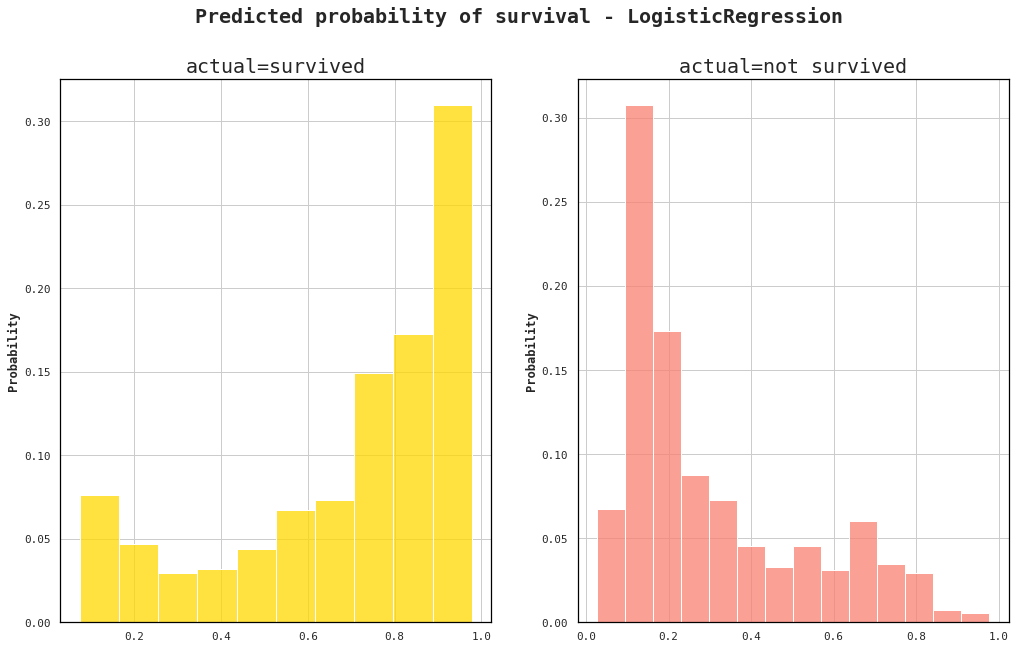

In [305]:
# having chosen the best model in CV, the Train performance below might not represent the actual Test performance 
evaluate(lr, X=X_train_norm, y=y_train, features_names=features_names, feature_importance=False)
plot_predicated_probability(lr, X_train_norm, y=y_train, y_label=y_label)

### SVM <a class="anchor" id="svm"></a>

#### Theoritical backgroud


<b>Hyperplane</b> of an n-dimensional space V is an affine subspace of dimension n − 1.

Can be represented by $\mathbf{w} \in \mathbb{R}^{n}$  such that $\mathbf{w}^{T}x + b = 0$ (orthogonal complement of a subspace span($\mathbf{w}$)) 

or equivalently as $U+v_{0}$, such that $U\subseteq V, v_0 \in \mathbb{R}^{n}$.

The signed distance of any point x to L is given by $\frac{\mathbf{w}^{T}x + b}{\| \mathbf{w} \|}$

<b>"Seperable" case - Hard-SVM</b>

Let there ($\mathbf{x}_{1}, \mathbf{y}_{1}),...,(\mathbf{x}_{n}, \mathbf{y}_{n})$ where $\mathbf{x}_{1}\in \mathbb{R}^{n}$ and $\mathbf{y}_{i}$ are either 1 or −1.
We want to find the "maximum-margin hyperplane" that divides the group of points $\mathbf{x}_{i}$ that the distance between the hyperplane and the nearest point from either group is maximized.

$\begin{aligned}
\max\limits_{\mathbf{w},b,\| \mathbf{w} \|=1} \quad & M\\
\textrm{s.t} \quad &\mathbf{y}_{i}(\mathbf{w}^{T}\mathbf{x}_{i} + b)\geq M, i=1,..,n
\end{aligned}$
 
 this optimization problem is equivalent to the convex problem:
 
$\begin{aligned}
\min\limits_{\mathbf{w},b} \quad & \frac{1}{2}{\| \mathbf{w} \|}^2\\
\textrm{s.t} \quad &\mathbf{y}_{i}(\mathbf{w}^{T}\mathbf{x}_{i} + b)\geq 1, i=1,..,n
\end{aligned}$


<b>Soft-SVM:</b>

Extension of SVM to cases in which data is not lineary seperable.

Let's define the hinge loss function:

$\max(0, 1-\mathbf{y}_{i}(\mathbf{w}^T\mathbf{x}_{i})+b)$

The goal of the optimization then is to minimize

$\begin{aligned}
\min\limits_{\mathbf{w},b} \quad \| \mathbf{w} \|^{2} + \lambda [\frac{1}{n}\sum_{i=1}^{n}
\max(0, 1-\mathbf{y}_{i}(\mathbf{w}^T\mathbf{x}_{i})+b)]\end{aligned}$


where the parameter 
$\lambda$ determines the trade-off between increasing the margin size and ensuring that the 
$\mathbf{x} _{i}$ lie on the correct side of the margin.

#### Random Search

In [940]:
search_param_grid = [
    # linear kernel:
    {
    'C': np.logspace(-3, 4, 20),        # regularization parameter, log scale
    'kernel': ['linear'],
    'class_weight':['balanced',None]    # weighted loss function - set the parameter C of class i to class_weight[i]*C 
    },
    
    # poly kernel:
    {
    'C': np.logspace(-3, 4, 20),        # regularization parameter, log scale. 
    'kernel': ['poly'],
    'gamma':["scale", "auto"],          # auto=1/p.  scale=(1/n*X.var)
    'class_weight':['balanced',None]    # weighted loss function - set the parameter C of class i to class_weight[i]*C
    'degree':[2,3]
    },
    
    # rbf kernel:
    {
    'C': np.logspace(-3, 4, 20),        # regularization parameter, log scale
    'kernel': ['rbf'],
    'gamma':["scale", "auto"],          # auto=1/p.  scale=(1/n*X.var)
    'class_weight':['balanced',None]    # weighted loss function - set the parameter C of class i to class_weight[i]*C
    },
]



svm = SVC()                     

clf = RandomizedSearchCV(svm, search_param_grid,  cv=2, scoring = ['accuracy', 'f1','precision','recall','roc_auc'],
                         refit=False, verbose=1,  n_iter=50,return_train_score=True)

In [ ]:
clf.fit(X_train_norm, y_train.values.ravel())

results_svm = pd.DataFrame(clf.cv_results_).fillna("None")
results_svm.to_csv(f'RandomSearch_results/{svm.__class__.__name__}.csv')

In [976]:
# choose the best params based on CV mean score:
score = 'accuracy'  # scoring func
params = results_svm.sort_values(f'mean_test_{score}', ascending=False).iloc[0]['params']
print(params)

# fit model based on optimal params
svm = SVC(**params)
params['probability']=True
svm.fit(X_train_norm, y_train.values.ravel())

all_classifiers[svm.__class__.__name__] = svm

{'kernel': 'poly', 'gamma': 'auto', 'class_weight': None, 'C': 26.366508987303554, 'probability': True}


In [942]:
evaluate(svm, X=X_train_norm, y=y_train)

              precision    recall  f1-score   support

           0       0.82      0.95      0.88       549
           1       0.90      0.67      0.77       342

    accuracy                           0.85       891
   macro avg       0.86      0.81      0.83       891
weighted avg       0.85      0.85      0.84       891

mean_of_predict=0.29 (actual = 0.38%)


0.7692307692307692

#### Results Analysis

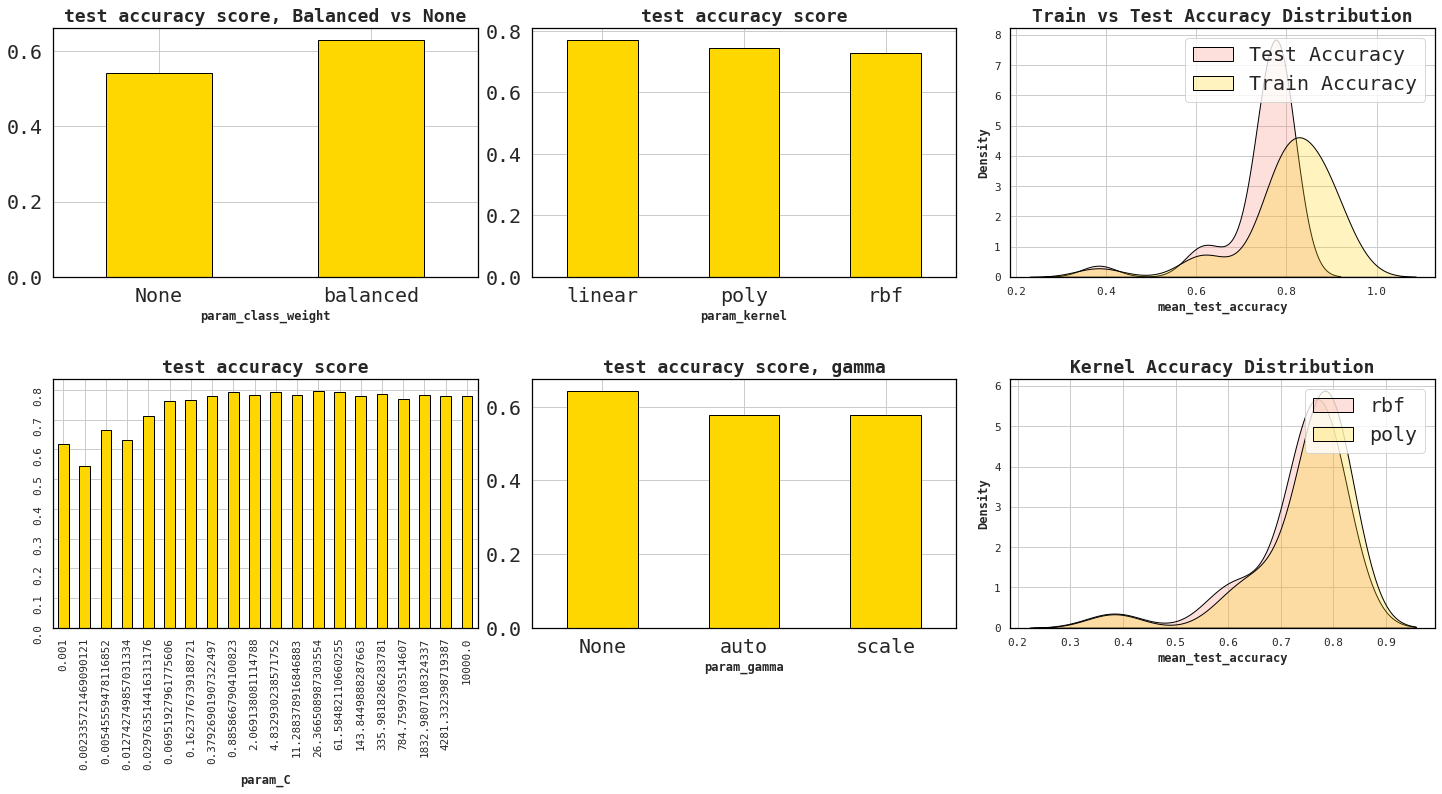

In [973]:
def plot_results_vs_param(param, results, score = 'accuracy', data='test',ax=None , title = '', color=color_main):
    results.groupby(f"param_{param}")[f"mean_{data}_{score}"].mean().plot(kind='bar', edgecolor="black", color=color, ax=ax).set_title(title)

# plot settings
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(20,11))
index, ax = 0, ax.flatten()

# compare f1 score of class_weight=Balanced vs class_weight=None
plot_results_vs_param("class_weight", results_svm, ax=ax[0], score = 'f1', data="test",title=f"test {score} score, Balanced vs None")
ax[0].tick_params(labelrotation=0)
ax[0].tick_params(axis='both', which='major', labelsize=20, labelrotation=0)


# compare accuracy score of different kernels
plot_results_vs_param("kernel", results_svm[results_svm["param_class_weight"] == "balanced"], ax=ax[1], score = 'accuracy', data="test",title=f"test {score} score")
ax[1].tick_params(axis='both', which='major', labelsize=20, labelrotation=0)

# compare accuracy scores train vs test:
score = 'accuracy'
sns.kdeplot(data=results_svm[results_svm["param_class_weight"] == "balanced"], x=f"mean_{data}_{score}", shade=True, edgecolor="black",color=my_colors[1], label=f"test_{score}", ax=ax[2])
sns.kdeplot(data=results_svm[results_svm["param_class_weight"] == "balanced"], x=f"mean_train_{score}", shade=True, edgecolor="black",color=my_colors[0], label=f"train_{score}", ax=ax[2]).set_title("Train vs Test Accuracy Distribution")
ax[2].legend(labels=['Test Accuracy','Train Accuracy'], prop={'size': 20})


# compare accuracy score of class_weight=Balanced vs class_weight=None
plot_results_vs_param("C", results_svm, ax=ax[3], score = 'accuracy', data="test",title=f"test {score} score")
ax[3].tick_params(labelrotation=90)

# compare accuracy score of gamma
plot_results_vs_param("gamma", results_svm, ax=ax[4], score = 'f1', data="test",title=f"test {score} score, gamma")
ax[4].tick_params(labelrotation=0)
ax[4].tick_params(axis='both', which='major', labelsize=20, labelrotation=0)


# compare accuracy scores for different kerenel
score, data = 'accuracy', "test"
sns.kdeplot(data=results_svm[(results_svm["param_class_weight"] == "balanced") & (results_svm["param_kernel"] == "rbf")], 
            x=f"mean_{data}_{score}", shade=True, edgecolor="black",color=my_colors[1], label="rbf", ax=ax[5])
sns.kdeplot(data=results_svm[(results_svm["param_class_weight"] == "balanced") & (results_svm["param_kernel"] == "poly")], 
            x=f"mean_{data}_{score}", shade=True, edgecolor="black",color=my_colors[0], label="poly", ax=ax[5]).set_title("Kernel Accuracy Distribution")
ax[5].legend(labels=['rbf','poly'], prop={'size': 20})

plt.tight_layout(pad=0.5, w_pad=0.7, h_pad=3.0)
plt.savefig(f"./images/SVM_search_results.png") 

### KNN <a class="anchor" id="knn"></a>
#### Theoritical backgroud
Given a query point $\mathbf{x}_0$, we find the k training points $\mathbf{x}_{r}$,r = 1,...,k closest in distance to $\mathbf{x}_0$, and then classify using majority vote among the k neighbors.

<b>NOTE:</b> I have standardize each of the features to have mean zero and variance 1, since it is possible that they are measured in different units.

Because it uses only the training point closest to the query point, the bias of the 1-nearest-neighbor estimate is often low, but the variance is high; on the other hand, using k=N for N the number of data points will result in high bias and low variance.

params:
* **n_neighbors** - number of neighbors to use. The more used the lower the variance and the higehr the bias. If we use n=number of data points, we get a uniform prediction, and if we use n=1 we get highly variable prediction. 
* **weights** - uniform weights will predicts the average of the neighbors, whereas "distance" option will take the distance-weighted-average of the neighbors. If we used distance-weighted average, the number of neighbors parametrs will have a reduced effect on prediction. 


#### Random Search

In [985]:
search_param = {
    'n_neighbors' : np.arange(1,100,2),
}

# seting, but not searching the following:
fixed_params = {
    'p':2,                                # l2 norm
    'metric':"minkowski",  
    'weights':'uniform'
}

knn = KNeighborsClassifier(**fixed_params)
clf = RandomizedSearchCV(knn, search_param,  cv=5, scoring = ['accuracy', 'f1','precision','recall','roc_auc'],
                         refit=False, verbose=1,  n_iter=100,return_train_score=True)

In [991]:
clf.fit(X_train_norm, y_train.values.ravel())
results_knn = pd.DataFrame(clf.cv_results_)
results_knn = pd.DataFrame(clf.cv_results_).fillna("None")
results_knn.to_csv(f'RandomSearch_results/{svm.__class__.__name__}.csv')

Fitting 5 folds for each of 50 candidates, totalling 250 fits


#### Results Analysis
* 25 neighboors seems to be the optimal number for this data
* I didn't use distance-weighted average
* In extremely high number of neighboors, the ratio Test/Train seems to converges to 1

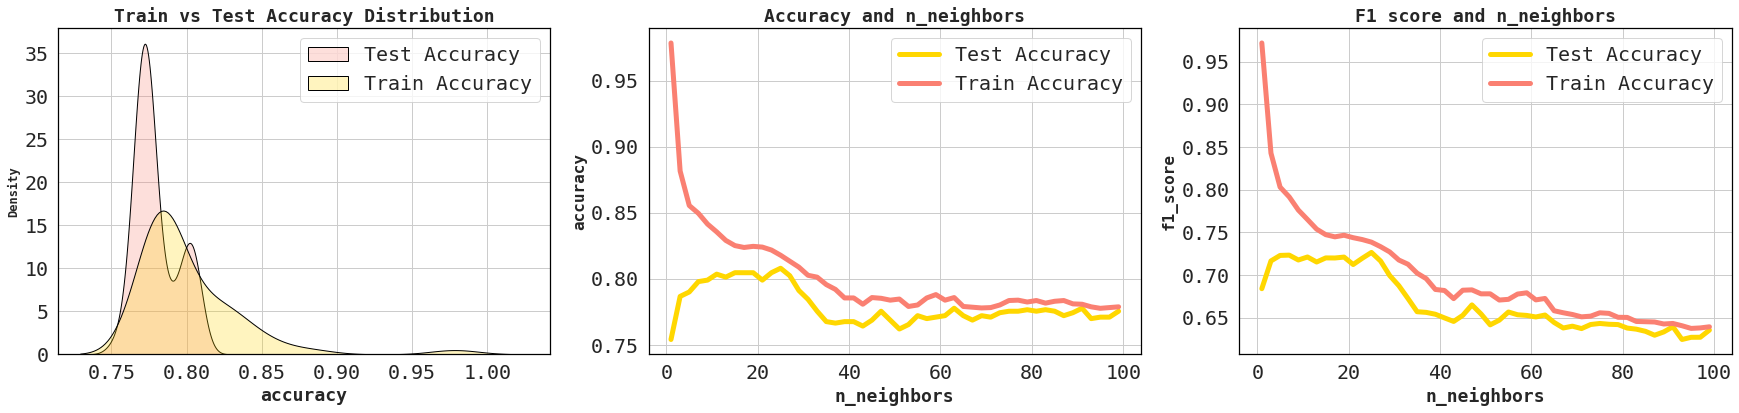

In [992]:
# plot settings
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(30,6))
index, ax = 0, ax.flatten()

# compare f1 score of class_weight=Balanced vs class_weight=None

# compare accuracy scores train vs test:
score = 'accuracy'
sns.kdeplot(data=results_knn, x=f"mean_{data}_{score}",shade=True ,edgecolor="black", color=my_colors[1], label=f"test_{score}", ax=ax[0])
sns.kdeplot(data=results_knn, x=f"mean_train_{score}", shade=True, edgecolor="black",color=my_colors[0], label=f"train_{score}", ax=ax[0]).set_title("Train vs Test Accuracy Distribution")
ax[0].legend(labels=['Test Accuracy','Train Accuracy'], prop={'size': 20})
ax[0].tick_params(axis='both', which='major', labelsize=20, labelrotation=0)
ax[0].set_xlabel('accuracy', fontsize=18)

sns.lineplot(data=results_knn, x="param_n_neighbors", y="mean_test_accuracy",color=my_colors[0], ax=ax[1], label="test").set_title("Accuracy and n_neighbors")
sns.lineplot(data=results_knn, x="param_n_neighbors", y="mean_train_accuracy", color=my_colors[1],ax=ax[1], label="train")
ax[1].legend(labels=['Test Accuracy','Train Accuracy'], prop={'size': 20})
ax[1].set_xlabel('n_neighbors', fontsize=18)
ax[1].set_ylabel('accuracy', fontsize=16)
ax[1].tick_params(axis='both', which='major', labelsize=20, labelrotation=0)

sns.lineplot(data=results_knn, x="param_n_neighbors", y="mean_test_f1",color=my_colors[0], ax=ax[2], label="test").set_title("F1 score and n_neighbors")
sns.lineplot(data=results_knn, x="param_n_neighbors", y="mean_train_f1", color=my_colors[1],ax=ax[2], label="train")
ax[2].legend(labels=['Test Accuracy','Train Accuracy'], prop={'size': 20})
ax[2].set_xlabel('n_neighbors', fontsize=18)
ax[2].set_ylabel('f1_score', fontsize=16)
ax[2].tick_params(axis='both', which='major', labelsize=20, labelrotation=0)
plt.savefig(f"./images/knn_search_results.png") 


In [993]:
# choose the best params based on CV mean score:

score = 'accuracy'  # scoring func
params = results_knn.sort_values(f'mean_test_{score}', ascending=False).iloc[0]['params']
print(params)

# set params:
params = {**fixed_params, **params}
print(params)

# fit the model on all data:
knn = KNeighborsClassifier(**params)
knn.fit(X_train_norm, y_train.values.ravel())

all_classifiers[knn.__class__.__name__] = knn

{'n_neighbors': 25}
{'p': 2, 'metric': 'minkowski', 'weights': 'uniform', 'n_neighbors': 25}


In [994]:
# having chosen the best model in CV, the Train performance below might not represent the actual Test performance 
evaluate(knn, X_train_norm, y_train)

              precision    recall  f1-score   support

           0       0.81      0.93      0.87       549
           1       0.85      0.65      0.74       342

    accuracy                           0.82       891
   macro avg       0.83      0.79      0.80       891
weighted avg       0.83      0.82      0.82       891

mean_of_predict=0.29 (actual = 0.38%)


0.7396351575456054

#### Results Analysis
Each passanger is assigned to a k-passangers group that best resembles him/her. It is intersting to ask how diverse is this group. Do the neighboors always share the same class? Sex? 

It turns out, virtually all neighboors in the above model shared the same Embarked, Sex, has_family and Pclass values, and the mean Age standard deviation between them is only 3. This indicates the groups are very much homogeneous.

In [563]:
# get neighboors matrix. Each row i represents the neighboors of passanger i.
neig_mat = pd.DataFrame(knn.kneighbors()[1])

def get_neighboors_by_inx(i):
    """ returns a slice of the data, containing only the neighboors of passanger i """
    tmp = X_train.iloc[neig_mat.iloc[i].values]
    tmp[y_label] = y_train.values.ravel()[neig_mat.iloc[i].values]
    return tmp
def std_group(field, inx):
    """ returns the standard deviation of the field amoung the neighboors of passanger inx """
    return get_neighboors_by_inx(inx)[field].std()

columns = ["Feature", "Mean standard deviation among neighboors"]

pd.DataFrame([[field,np.mean(list(map((lambda x:std_group(field=field, inx=x)), range(len(X_train)))))]  for field in features_names], columns = columns).sort_values(columns[1])

,Feature,Mean standard deviation among neighboors
4,Embarked_Q,0.001327
5,Embarked_S,0.023620
6,has_family,0.053725
1,Sex_male,0.059173
3,ranked_fare,0.123217
0,Pclass,0.219885
2,Age,6.170420


## Analyze all models <a class="anchor" id="analze"></a>
having chosen the best model in CV, the Train performance below might not represent the actual Test performance 

In [995]:
def get_scores_df(all_classifiers, scores_funcs = [f1_score, accuracy_score, precision_score, recall_score]):
    """ create a table of models and different scoring functions """
    models_score = [[model] + [score(all_classifiers[model].predict(X_train_norm), y_train) for score in scores_funcs] for model in all_classifiers]
    return pd.DataFrame(models_score, columns = ["model"] + [f.__name__ for f in scores_funcs])

get_scores_df(all_classifiers)

,model,f1_score,accuracy_score,precision_score,recall_score
0,SVC,0.769231,0.845118,0.672515,0.898438
1,RandomForestClassifier,0.829971,0.867565,0.842105,0.818182
2,LogisticRegression,0.742466,0.789001,0.792398,0.698454
3,KNeighborsClassifier,0.739635,0.823793,0.652047,0.854406


**roc curve**

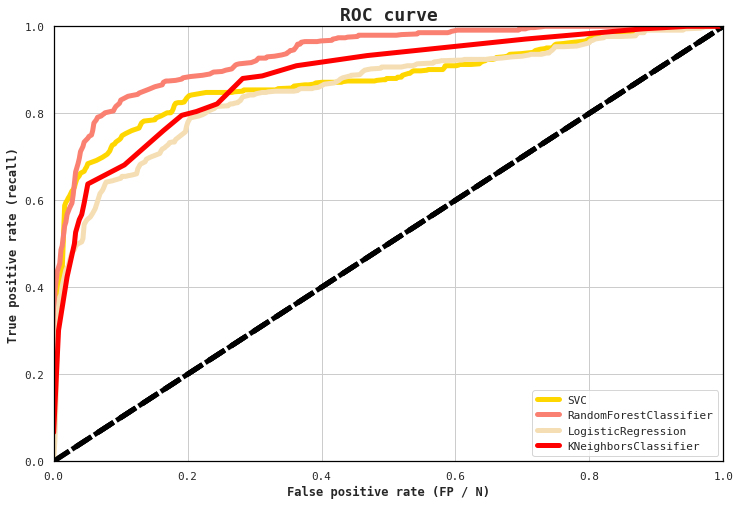

In [996]:
i=0
for model_name, model in all_classifiers.items():
    plot_roc_curve(model,X_train_norm,y_train, color=my_colors[i], ax=None, label=model_name)
    i+=1

In [997]:
# get all prediction in a dataframe:
models_mat = pd.DataFrame([all_classifiers[model].predict(X_train_norm) for model in all_classifiers], index = list(all_classifiers.keys())).T

# get correlation:
models_corr_mat = models_mat.corr()

# add actual values
models_mat["actual"] = y_train

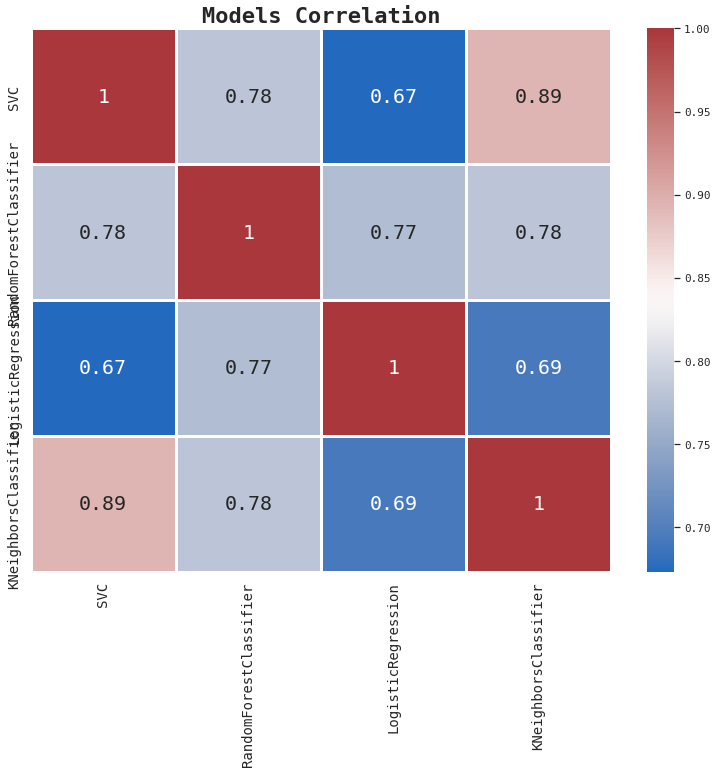

In [999]:
fig, ax = plt.subplots(figsize=(13,10)) 

models = list(all_classifiers.keys())

title = 'Models Correlation'
sns.heatmap(models_corr_mat, annot=True, cmap='vlag',fmt='.2g',linewidths=3, ax=ax,annot_kws={"fontsize":20}).set_title(title, fontsize=22)
ax.set_xticklabels(models, fontsize=14)
ax.set_yticklabels(models,fontsize=14)
ax.tick_params(labelrotation=90)

## Error Analysis
**Majority Rule classifier**

* Next we combine all models into a simple majority-rule classifer. 
* To consider ways to improve out models, we compare the distrubtion of the orginial data conditioned on our model making a mistake. For example, the set of passangers for which our model made an error has slightly less siblines on board (SibSp) compared to the passangers with correct prediction. This indicats, our model hasn't fully encode the informtion in this feature. 

In [1000]:
all_models = list(all_classifiers.keys())
tmp_models_mat = models_mat
tmp_models_mat["average"] = models_mat[all_models].mean(axis=1).round().astype(int)

models_error_inx = list(tmp_models_mat[tmp_models_mat["average"] != tmp_models_mat["actual"]].index)
errors = train_df[train_df.index.isin(models_error_inx)]

tmp=train_df.copy()
tmp["is_error"] = train_df.index.isin(models_error_inx)
display(tmp.groupby("is_error").mean())

print(classification_report(tmp_models_mat["actual"], tmp_models_mat["average"], target_names=class_names))

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,age_null,has_family,ranked_fare
is_error,,,,,,,,,,
False,445.916779,0.310067,2.311409,29.841132,0.550336,0.390604,31.764406,0.0,0.395973,0.501461
True,446.424658,0.760274,2.294521,29.313409,0.383562,0.335616,34.448403,0.0,0.404110,0.502817


              precision    recall  f1-score   support

        Died       0.82      0.94      0.88       549
    Survived       0.87      0.68      0.76       342

    accuracy                           0.84       891
   macro avg       0.85      0.81      0.82       891
weighted avg       0.84      0.84      0.83       891



In [1001]:
# generate submission file 
test_models_mat = pd.DataFrame([all_classifiers[model].predict(X_test_norm) for model in all_classifiers], index = list(all_classifiers.keys())).T
pred = test_models_mat.mean(axis=1).round().astype(int)
pred_df = pd.DataFrame({"PassengerId":test_df['PassengerId'], "Survived":pred})
display(pred_df)
pred_df.to_csv("test_pred.csv", index=False)


,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
